In [1]:
%matplotlib inline


# Max-tree

The max-tree is a hierarchical representation of an image that is the basis
for a large family of morphological filters.

If we apply a threshold operation to an image, we obtain a binary image
containing one or several connected components. If we apply a lower
threshold, all the connected components from the higher threshold are
contained in the connected components from the lower threshold. This
naturally defines a hierarchy of nested components that can be
represented by a tree. whenever a connected component A obtained by
thresholding with threshold t1 is contained in a component B obtained by
thresholding with threshold t1 < t2, we say that B is the parent of A.
The resulting tree structure is called a component tree. The max-tree
is a compact representation of such a component tree. [1]_, [2]_, [3]_, [4]_

In this example we give an intuition of what a max-tree is.

## References
.. [1] Salembier, P., Oliveras, A., & Garrido, L. (1998). Antiextensive
       Connected Operators for Image and Sequence Processing.
       IEEE Transactions on Image Processing, 7(4), 555-570.
       :DOI:`10.1109/83.663500`
.. [2] Berger, C., Geraud, T., Levillain, R., Widynski, N., Baillard, A.,
       Bertin, E. (2007). Effective Component Tree Computation with
       Application to Pattern Recognition in Astronomical Imaging.
       In International Conference on Image Processing (ICIP) (pp. 41-44).
       :DOI:`10.1109/ICIP.2007.4379949`
.. [3] Najman, L., & Couprie, M. (2006). Building the component tree in
       quasi-linear time. IEEE Transactions on Image Processing, 15(11),
       3531-3539.
       :DOI:`10.1109/TIP.2006.877518`
.. [4] Carlinet, E., & Geraud, T. (2014). A Comparative Review of
       Component Tree Computation Algorithms. IEEE Transactions on Image
       Processing, 23(9), 3885-3895.
       :DOI:`10.1109/TIP.2014.2336551`


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from skimage.morphology import max_tree
import networkx as nx

Before we start : a few helper functions



In [3]:
def plot_img(ax, image, title, plot_text, image_values):
    """Plot an image, overlaying image values or indices."""
    ax.imshow(image, cmap='gray', aspect='equal', vmin=0, vmax=np.max(image))
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

    for x in np.arange(-0.5, image.shape[0], 1.0):
        ax.add_artist(Line2D((x, x), (-0.5, image.shape[0] - 0.5),
                             color='blue', linewidth=2))

    for y in np.arange(-0.5, image.shape[1], 1.0):
        ax.add_artist(Line2D((-0.5, image.shape[1]), (y, y),
                             color='blue', linewidth=2))

    if plot_text:
        for i, j in np.ndindex(*image_values.shape):
            ax.text(j, i, image_values[i, j], fontsize=8,
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='red')
    return


def prune(G, node, res):
    """Transform a canonical max tree to a max tree."""
    value = G.nodes[node]['value']
    res[node] = str(node)
    preds = [p for p in G.predecessors(node)]
    for p in preds:
        if (G.nodes[p]['value'] == value):
            res[node] += ', %i' % p
            G.remove_node(p)
        else:
            prune(G, p, res)
    G.nodes[node]['label'] = res[node]
    return


def accumulate(G, node, res):
    """Transform a max tree to a component tree."""
    total = G.nodes[node]['label']
    parents = G.predecessors(node)
    for p in parents:
        total += ', ' + accumulate(G, p, res)
    res[node] = total
    return total


def position_nodes_for_max_tree(G, image_rav, root_x=4, delta_x=1.2):
    """Set the position of nodes of a max-tree.

    This function helps to visually distinguish between nodes at the same
    level of the hierarchy and nodes at different levels.
    """
    pos = {}
    for node in reversed(list(nx.topological_sort(canonical_max_tree))):
        value = G.nodes[node]['value']
        if canonical_max_tree.out_degree(node) == 0:
            # root
            pos[node] = (root_x, value)

        in_nodes = [y for y in canonical_max_tree.predecessors(node)]

        # place the nodes at the same level
        level_nodes = [y for y in
                       filter(lambda x: image_rav[x] == value, in_nodes)]
        nb_level_nodes = len(level_nodes) + 1

        c = nb_level_nodes // 2
        i = - c
        if (len(level_nodes) < 3):
            hy = 0
            m = 0
        else:
            hy = 0.25
            m = hy / (c - 1)

        for level_node in level_nodes:
            if(i == 0):
                i += 1
            if (len(level_nodes) < 3):
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x, value)
            else:
                pos[level_node] = (pos[node][0] + i * 0.6 * delta_x,
                                   value + m * (2 * np.abs(i) - c - 1))
            i += 1

        # place the nodes at different levels
        other_level_nodes = [y for y in
                             filter(lambda x: image_rav[x] > value, in_nodes)]
        if (len(other_level_nodes) == 1):
            i = 0
        else:
            i = - len(other_level_nodes) // 2
        for other_level_node in other_level_nodes:
            if((len(other_level_nodes) % 2 == 0) and (i == 0)):
                i += 1
            pos[other_level_node] = (pos[node][0] + i * delta_x,
                                     image_rav[other_level_node])
            i += 1

    return pos


def plot_tree(graph, positions, ax, *, title='', labels=None,
              font_size=8, text_size=8):
    """Plot max and component trees."""
    nx.draw_networkx(graph, pos=positions, ax=ax,
                     node_size=40, node_shape='s', node_color='white',
                     font_size=font_size, labels=labels)
    xlimit = ax.get_xlim()
    for v in range(image_rav.min(), image_rav.max() + 1):
        ax.hlines(v - 0.5, -3, 10, linestyles='dotted')
        ax.text(-3, v - 0.15, "val: %i" % v, fontsize=text_size)
    ax.hlines(v + 0.5, -3, 10, linestyles='dotted')
    ax.set_xlim(-3, 10)
    ax.set_title(title)
    ax.set_axis_off()

### Image Definition
We define a small test image.
For clarity, we choose an example image, where image values cannot be
confounded with indices (different range).



In [4]:
image = np.array([[40, 40, 39, 39, 38],
                  [40, 41, 39, 39, 39],
                  [30, 30, 30, 32, 32],
                  [33, 33, 30, 32, 35],
                  [30, 30, 30, 33, 36]], dtype=np.uint8)

### Max-tree
Next, we calculate the max-tree of this image.
max-tree of the image



In [5]:
P, S = max_tree(image)

P_rav = P.ravel()

### Image plots
Then, we visualize the image and its raveled indices.
Concretely, we plot the image with the following overlays:
- the image values
- the raveled indices (serve as pixel identifiers)
- the output of the max_tree function



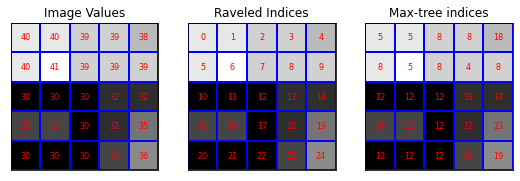

In [6]:
# raveled image
image_rav = image.ravel()

# raveled indices of the example image (for display purpose)
raveled_indices = np.arange(image.size).reshape(image.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(9, 3))

plot_img(ax1, image - image.min(), 'Image Values',
         plot_text=True, image_values=image)
plot_img(ax2, image - image.min(), 'Raveled Indices',
         plot_text=True, image_values=raveled_indices)
plot_img(ax3, image - image.min(), 'Max-tree indices',
         plot_text=True, image_values=P)

### Visualizing threshold operations
Now, we investigate the results of a series of threshold operations.
The component tree (and max-tree) provide representations of the
inclusion relationships between connected components at different
levels.



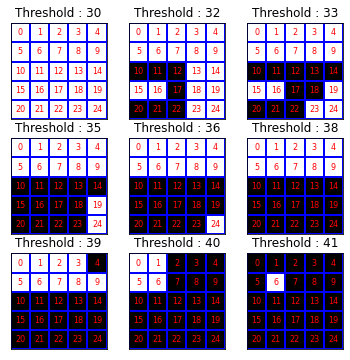

In [7]:
fig, axes = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(6, 6))
thresholds = np.unique(image)
for k, threshold in enumerate(thresholds):
    bin_img = image >= threshold
    plot_img(axes[(k // 3), (k % 3)], bin_img, 'Threshold : %i' % threshold,
             plot_text=True, image_values=raveled_indices)

### Max-tree plots
Now, we plot the component and max-trees. A component tree relates
the different pixel sets resulting from all possible threshold operations
to each other. There is an arrow in the graph, if a component at one level
is included in the component of a lower level. The max-tree is just
a different encoding of the pixel sets.

1. the component tree: pixel sets are explicitly written out. We see for
   instance that {6} (result of applying a threshold at 41) is the parent
   of {0, 1, 5, 6} (threshold at 40).
2. the max-tree: only pixels that come into the set at this level
   are explicitly written out. We therefore will write
   {6} -> {0,1,5} instead of {6} -> {0, 1, 5, 6}
3. the canonical max-treeL this is the representation which is given by
   our implementation. Here, every pixel is a node. Connected components
   of several pixels are represented by one of the pixels. We thus replace
   {6} -> {0,1,5} by {6} -> {5}, {1} -> {5}, {0} -> {5}
   This allows us to represent the graph by an image (top row, third column).



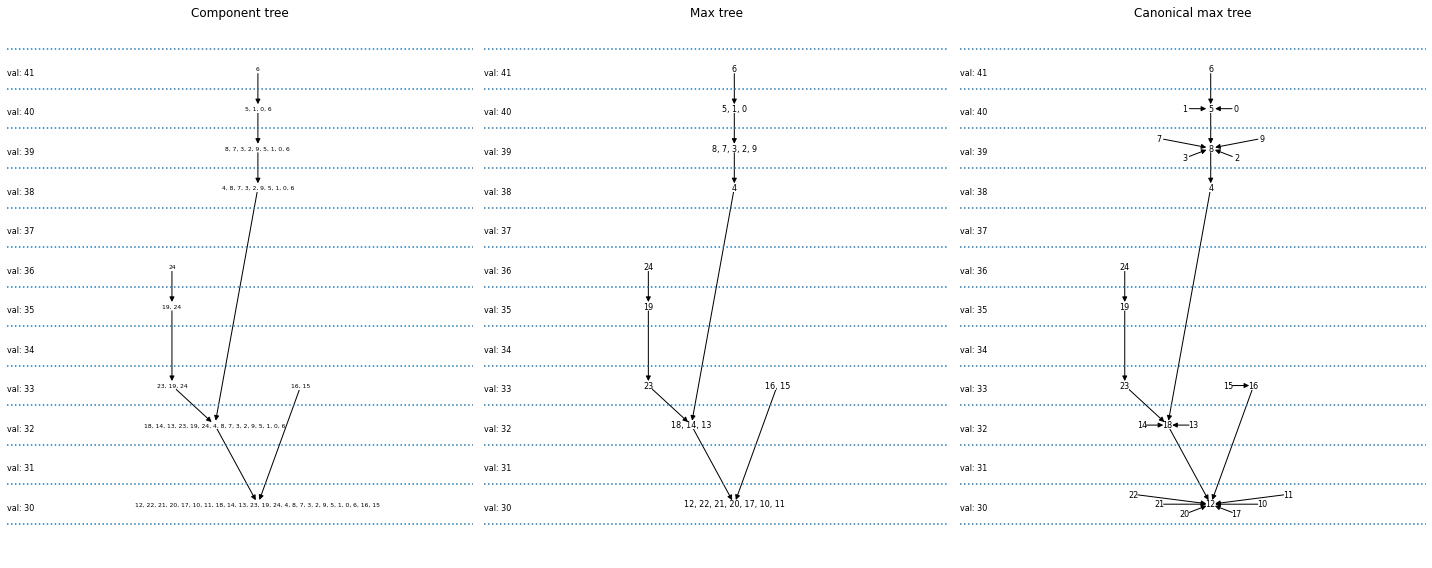

In [8]:
# the canonical max-tree graph
canonical_max_tree = nx.DiGraph()
canonical_max_tree.add_nodes_from(S)
for node in canonical_max_tree.nodes():
    canonical_max_tree.nodes[node]['value'] = image_rav[node]
canonical_max_tree.add_edges_from([(n, P_rav[n]) for n in S[1:]])

# max-tree from the canonical max-tree
nx_max_tree = nx.DiGraph(canonical_max_tree)
labels = {}
prune(nx_max_tree, S[0], labels)

# component tree from the max-tree
labels_ct = {}
total = accumulate(nx_max_tree, S[0], labels_ct)

# positions of nodes : canonical max-tree (CMT)
pos_cmt = position_nodes_for_max_tree(canonical_max_tree, image_rav)

# positions of nodes : max-tree (MT)
pos_mt = dict(zip(nx_max_tree.nodes, [pos_cmt[node]
                                      for node in nx_max_tree.nodes]))

# plot the trees with networkx and matplotlib
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 8))

plot_tree(nx_max_tree, pos_mt, ax1, title='Component tree',
          labels=labels_ct, font_size=6, text_size=8)

plot_tree(nx_max_tree, pos_mt, ax2, title='Max tree', labels=labels)

plot_tree(canonical_max_tree, pos_cmt, ax3, title='Canonical max tree')

fig.tight_layout()

plt.show()